### Step_1 - Подготовка к работе (Preparation for work)

In [74]:
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [75]:
#Путь к данным
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### Step_2 - Работа с данными (Exploratory data analysis)

In [76]:
#Анализ данных
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [77]:
#Посчитаем количество пропущенных значений в наших исходных данных
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Видно, что нет многих данных о возрасте пассажира(177/889=0,199) и номере каюты(687/889=0,772). Предположительное решение: Данные о возрасте пассажира я бы заменил на медианные значения. Все таки пропущено только около 20% данных.

А вот данные о каюте я исключу. Безусловно, узнав местоположение каюты можно улучшить предсказание. Т.к. Чем ниже каюта, тем выше вероятность смерти пассажира. Но! Во-первых пропуск данных достаточно большой, около 77%. Во-вторых я новичок. Пока не обладаю достаточным набором знаний для заполнения пропущенных данных. Но вообще думаю возможно было бы обучить модель предсказывать/сортировать пассажиров по каютам по их билету и классу. Все таки номера билетов наверняка могут сказать расположении в классе(эконом,комфорт,бизнес). Да, человек может попасать в эконом класс и быть ближе к трюму. Вопрос в том, насколько глубоко он был относительно палубы. В будущем поищу подобную информацию об этом.

In [78]:
#Отбросим данные об имени (оно никак не поможет понять выживет человек или нет)
#Так же отбросим каюту, билет, номерпассажира)
#Порт в котором пассажир садился так же роли не играет Embarked
useless_columns = ['Name','Ticket','Cabin','Embarked']

train_clean = train_df.drop(columns=useless_columns)
test_clean = test_df.drop(columns=useless_columns)

#### Заполнение пропусков в данных

In [79]:
#imputing - заполнение пропущенных данных
#данная функция заполняет категориальные переменные модой(наиболее часто встречающееся)
#а количественные переменные медианой

def impute_data(df):
    df_copy = df.copy() # копируем, чтобы не изменить оригинальные данные
    
    #Заполняем категориальные переменные модой:
    categorial_vars = list(df_copy.select_dtypes(include=['object']).columns.values)
    for col in categorial_vars:
        if(df_copy[col].isnull().values.any()):
            df_copy[col].fillna(df_copy[col].mode()[0], inplace = True)
            
    #заполняем пропущенные значения для количественных переменных медианос по столбцу
    numerical_vars = list(df_copy.select_dtypes(include=['int64', 'float64']).columns.values)
    for col in numerical_vars:
        if(df_copy[col].isnull().values.any()):
            df_copy[col].fillna(df_copy[col].median(), inplace = True)
            
    return df_copy

In [80]:
train_full = impute_data(train_clean)
test_full = impute_data(test_clean)

In [81]:
#Проверим данные после заполнения
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
dtypes: float64(2), int64(5), object(1)
memory usage: 55.8+ KB


In [82]:
test_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         418 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 23.0+ KB


#### Визуализация данных

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


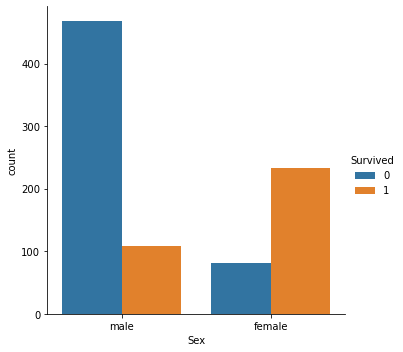

In [83]:
#зависимость смертности от пола
sns.catplot('Sex', data=train_full, hue='Survived', kind = 'count');
#Если ты - мужчина, плывущий на Титанике, скорее всего ты умрешь =)))

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


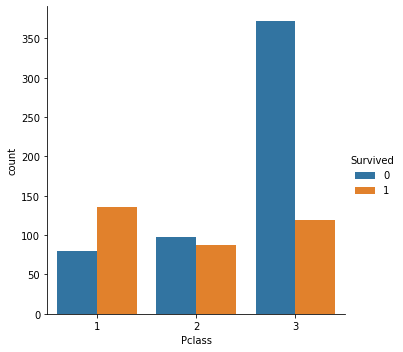

In [84]:
#зависимость смертности от достатка пассажира (каким классом плыл пассажир)
sns.catplot('Pclass', data=train_full, hue = 'Survived', kind = 'count');
#Если ты имеешь низкий уровень достатка, вероятнее всего, ты тоже умрешь =)
#Ну если серьезно, то чем выше класс, тем каюты находятся выше
#Соответственно при столкновении те, кто был ниже уровня палубы затонули быстрее((((

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


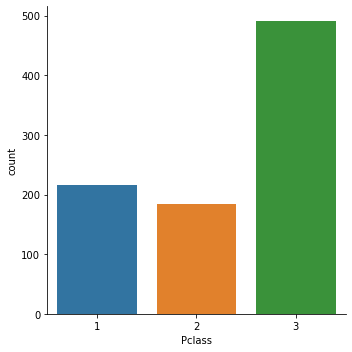

In [85]:
#Опять же пассажиров 3его класса было больше всего
sns.catplot('Pclass', data=train_full, kind='count');

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


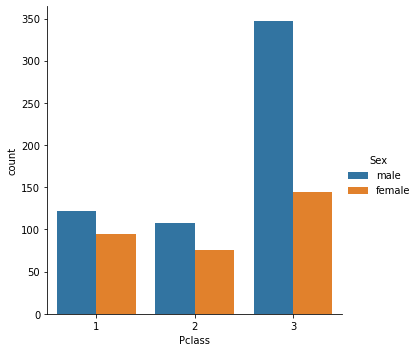

In [86]:
#Так же бедных мужчин было все, Леонардо наверное не смог залезть на дверь, т.к. он бедный и мужчина
sns.catplot('Pclass', data=train_full, hue='Sex', kind='count');

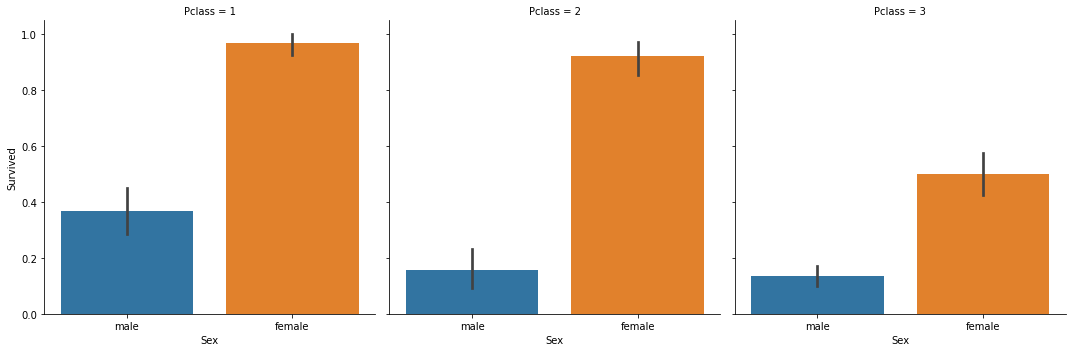

In [87]:
#Выживших среди них было меньше всего
sns.catplot(x='Sex', y='Survived', col='Pclass', data=train_full, kind='bar');

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


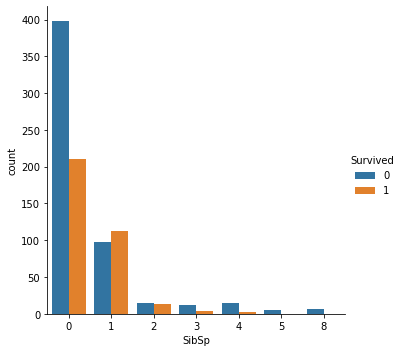

In [88]:
#от количества членов семьи так же зависит выживаемость
#Здесь это количество супругов+родственников пассажира(признак SibSp)
sns.catplot('SibSp', data=train_full, hue = 'Survived', kind='count');

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


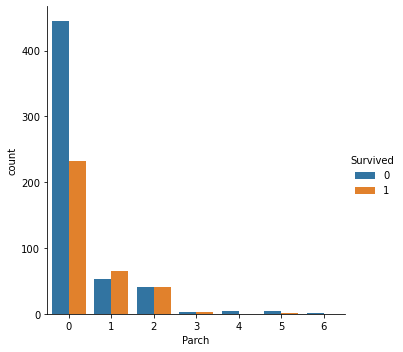

In [89]:
#от количества членов семьи так же зависит выживаемость
#Здесь это количество детей + родителей пассажира(признак Parch)
sns.catplot('Parch', data=train_full, hue = 'Survived', kind='count');

#### Feature Engineering 
Определив, что количество родственииков влияет на выживыемость пассажира.
Объединим эти признаки в один - "FamilySize"
Данное действие поможет нашей модели лучше обучиться на наших данных.

In [90]:
#Создаем новую колонку-признак
train_full['Family_size'] = train_full['Parch'] + train_full['SibSp']
test_full['Family_size'] = test_full['Parch'] + test_full['SibSp']

train_full.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Family_size
0,1,0,3,male,22.0,1,0,7.2500,1
1,2,1,1,female,38.0,1,0,71.2833,1
2,3,1,3,female,26.0,0,0,7.9250,0


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


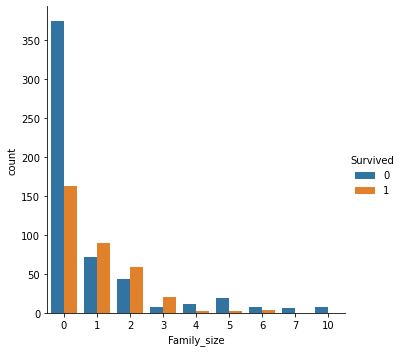

In [91]:
#Новый признак помогает лучше определить случаи, в которых люди выжили
sns.catplot('Family_size', data=train_full, hue='Survived', kind='count');

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


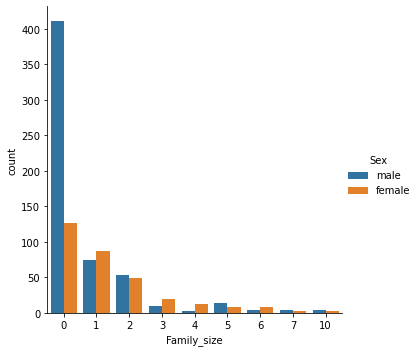

In [92]:
#Признак, в большей степени, касается женщин
sns.catplot('Family_size', data=train_full, hue='Sex', kind='count');

#### Сохранение обработанных данных

In [93]:
#Сохраним обработанные данные в файл, чтобы не потерять изменения.
train_full.to_csv('train_imputed.csv')
test_full.to_csv('test_imputed.csv')

#### На основании визуализированных данных сделаем предсказания
#### Очень простая baseline-модель (решающий пень, decision stump)

In [94]:
#все мужчины, которые плыли в 3ем классе - умерли
#таким образом получим булев вектор, содержащий условие
(test_full['Sex'] == 'male') & (test_full['Pclass'] == 3)

0       True
1      False
2      False
3       True
4      False
       ...  
413     True
414    False
415     True
416     True
417     True
Length: 418, dtype: bool

In [95]:
#Берем мужчин из 3его класса, как вектор предсказаний и говорим, что они не выжили

simple_pred = (~((test_full['Sex'] == 'male') & (test_full['Pclass'] == 3))).astype(int).values

#### Оформление результата

In [96]:
#функция для составления submission-файла соревнования
def make_prediction_file(prediction, test_data, name):
    
    result = pd.DataFrame({'PassengerId': test_data.reset_index()['PassengerId'], 'Survived': prediction})
    result.to_csv(name, index=False)

In [97]:
make_prediction_file(simple_pred, test_full,'titanic_simple_baseline.csv')

### ИТОГ
1 - Необходимо найти данные для работы

2 - Загрузка данных и их анализ.

3 - Проверка данных на наличие пропусков. Пропущенные данные необходимо заполнить. Неинформативные данные необходимо исключить.

4 - Визуализация данных. Необходима для того, чтобы было проще найти закономерности в данных.

5 - Создание нового признака, а лучше нескольких. (Визуализация может с этим помочь).

6 - На основании такого изучения возможно сделать первоначальные выводы, наброски решения.


Резюме: мы получили решающий пень - базовая baseline-модель. В ручную, благодаря  визуальному анализу отобрали признаки, которые помогли с 60% вероятность определить выживаемость пассажира. 

В следующей части буду использовать уже "настоящий" алгоритм машинного обучения - Decision Tree.